In [3]:
from __future__ import division
import numpy as np
import pandas as pd
import cPickle as pickle
import gzip

from joblib import Parallel, delayed
import multiprocessing
from methods.index_helpers import load_Kp
import matplotlib.pyplot as plt
import os
import itertools
import random
import os
import time
import datetime as datetime
import types
import scipy.io
import matplotlib.gridspec as gridspec


from scipy import stats
import xflib
import logging
import math
from mpl_toolkits.mplot3d import Axes3D
#%matplotlib inline
%matplotlib nbagg
# Autoload changes made in external editor:
%load_ext autoreload
%autoreload 2

from mpl_toolkits.axes_grid1 import make_axes_locatable
xf = xflib.xflib(lib_path='/shared/users/asousa/WIPP/3dWIPP/python/libxformd.so')
from scipy.integrate import nquad

from methods.GLD_file_tools import GLD_file_tools

In [4]:
data_path = '../lightning_power_study/outputs/GLDstats_v8/data/'

flash_map = np.zeros([180,360])
cur_map   = np.zeros([180,360])
pwr_map   = np.zeros([180,360])
mlt_hist  = np.zeros(48)

gridlats = np.arange(-90, 90, 1)
gridlons = np.arange(-180,180,1)

lookback_time = datetime.timedelta(hours=3)

d = os.listdir(data_path)
files = [x for x in d if x.endswith('.pklz')]
intimes = [datetime.datetime.strptime(x[:-5],'%m_%d_%Y_%H_%M') for x in d if x.endswith('.pklz')]

total_files = len(files)
count=0
for f_ind, filename in enumerate(files):
    print "loading %d/%d"%(f_ind, total_files)
    with gzip.open(os.path.join(data_path, filename)) as f:
        thingy = pickle.load(f)
        flash_map += thingy['flash_map']
        cur_map   += thingy['cur_map']
#         pwr_map   += thingy['pwr_map']
        mlt_hist  += thingy['mlt_hist']

flash_map /= 1.0*len(files)
cur_map  /= 1.0*len(files)
# pwr_map /= 1.0*len(files)

# # Working longitudes on [0, 360]... plotting longitudes on [-180, 180]
# flash_map = np.roll(flash_map, 180, axis=1)
# cur_map = np.roll(cur_map, 180, axis=1)
# pwr_map = np.roll(pwr_map, 180, axis=1)

loading 0/4696
loading 1/4696
loading 2/4696
loading 3/4696
loading 4/4696
loading 5/4696
loading 6/4696
loading 7/4696
loading 8/4696
loading 9/4696
loading 10/4696
loading 11/4696
loading 12/4696
loading 13/4696
loading 14/4696
loading 15/4696
loading 16/4696
loading 17/4696
loading 18/4696
loading 19/4696
loading 20/4696
loading 21/4696
loading 22/4696
loading 23/4696
loading 24/4696
loading 25/4696
loading 26/4696
loading 27/4696
loading 28/4696
loading 29/4696
loading 30/4696
loading 31/4696
loading 32/4696
loading 33/4696
loading 34/4696
loading 35/4696
loading 36/4696
loading 37/4696
loading 38/4696
loading 39/4696
loading 40/4696
loading 41/4696
loading 42/4696
loading 43/4696
loading 44/4696
loading 45/4696
loading 46/4696
loading 47/4696
loading 48/4696
loading 49/4696
loading 50/4696
loading 51/4696
loading 52/4696
loading 53/4696
loading 54/4696
loading 55/4696
loading 56/4696
loading 57/4696
loading 58/4696
loading 59/4696
loading 60/4696
loading 61/4696
loading 62/4696
lo

In [39]:
def plot_a_thing(datagrid,clims=[0,4]):
    fig_width = 5
    fig_height = 2.5
    fig_size =  [fig_width+1,fig_height+1]
    params = {'font.family': 'Sans Serif',
              'backend': 'ps',
              'axes.labelsize': 10,
              'font.size': 10,
              'legend.fontsize': 8,
              'xtick.labelsize': 10,
              'ytick.labelsize': 10,
              'text.usetex': False,
              'figure.figsize': fig_size}
    plt.rcParams.update(params)
    # --------------- Latex Plot Beautification --------------------------


    # Plot flash location with integrated current vs lat and lon:
    fig = plt.figure()
    gs = gridspec.GridSpec(2,3,width_ratios=[0.5,10,0.2],
                       height_ratios=[10,1])
    gs.update(wspace=0.05, hspace=0.05) # set the spacing between axes
    ax1 = plt.subplot(gs[0,1])  # main figure
    ax0 = plt.subplot(gs[0,0])   #
    ax2 = plt.subplot(gs[1,1])
    cbar_ax = plt.subplot(gs[:,2])
    pwr_bylat = np.sum(datagrid, axis=1)/lookback_time.total_seconds()
    pwr_bylon = np.sum(datagrid, axis=0)/lookback_time.total_seconds()

    logpwr = np.log10(datagrid/3600./3.0)  # Energy per second, in log space.
    logpwr[np.isinf(logpwr)] = -10

    

    p = ax1.pcolormesh(gridlons, gridlats, logpwr, cmap = plt.get_cmap('jet'), shading='gouraud')
    p.set_clim(clims)

    cb = plt.colorbar(p, cax=cbar_ax)

#     cb.set_label('Average Energy Flux [J/sec]')
    cticks = np.arange(clims[0],clims[1] + 1)
    cb.set_ticks(cticks)
    cticklabels = ['$10^{%d}$'%k for k in cticks]
    cb.set_ticklabels(cticklabels)

    ax0.spines['top'].set_linewidth(0)
    ax0.spines['right'].set_linewidth(0)
    ax0.spines['bottom'].set_linewidth(0)

    ax2.spines['top'].set_linewidth(0)
    ax2.spines['right'].set_linewidth(0)
    ax2.spines['left'].set_linewidth(0)


    
#     [j.set_linewidth(0) for j in ax0.spines.itervalues()]
#     [j.set_linewidth(0) for j in ax2.spines.itervalues()]
    

    lat_ticks = np.arange(-90, 91, 30)
    lon_ticks = np.arange(-180, 181, 45)
#     coast_lat_mag, coast_lon_mag = get_coast_mag(datetime.datetime(2010,1,1,0,0,0))
    coast_lat_mag = coast['lat']
    coast_lon_mag = coast['lon']
    ax1.plot(coast_lon_mag, coast_lat_mag, 'w', linewidth=0.8)
    ax1.set_xlim([-180, 180])
    ax1.set_ylim([-90, 90])
    p.set_clim(clims)
    ax1.set_yticks(lat_ticks)
    ax1.set_xticks(lon_ticks)
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax0.plot(pwr_bylat,gridlats, linewidth=1)
    ax0.set_ylim([-90,90])
    ax0.set_xticks([])
    ax0.set_yticks(lat_ticks)
    ax0.set_ylabel('Latitude (magnetic)')
    ax2.plot(gridlons, pwr_bylon, linewidth=1)
    ax2.set_xlim([-180,180])
    ax2.set_yticks([])
    ax2.set_xticks(lon_ticks)
    ax2.set_xlabel('Longitude (magnetic)')
#     ax1.set_aspect('equal')
#     gs.tight_layout(fig)
    fig.subplots_adjust(bottom=0.2, right=0.85)
    return fig, ax1, cb



In [9]:
# Load coastlines (for plotting)
with gzip.open('python_local/mag_coastlines.gzip','rb') as file:
    coast = pickle.load(file)
print coast.keys()

['lat', 'lon']


In [11]:
# HEY FUCKER
# ARE THESE NORMALIZED TO SQUARE METER OR SQUARE LAT-LON BIN
# FIGURE THAT PART OUT YOU FUCKIN' DICK

# Area of each cell, in km: 
R_E = 6371. # Km
R2D = 180./np.pi
D2R = np.pi/180.
dlon = gridlons[1] - gridlons[0]
dlat = gridlats[1] - gridlats[0]
print dlon, dlat

cell_areas = np.abs((R_E*dlat*D2R)*(R_E*dlon*D2R)*np.cos((np.abs(gridlats) + dlat/2.0)*D2R))
# fig, ax = plt.subplots(1,1)
# ax.plot(gridlats, cell_areas)

1 1


31557600.0


<IPython.core.display.Javascript object>


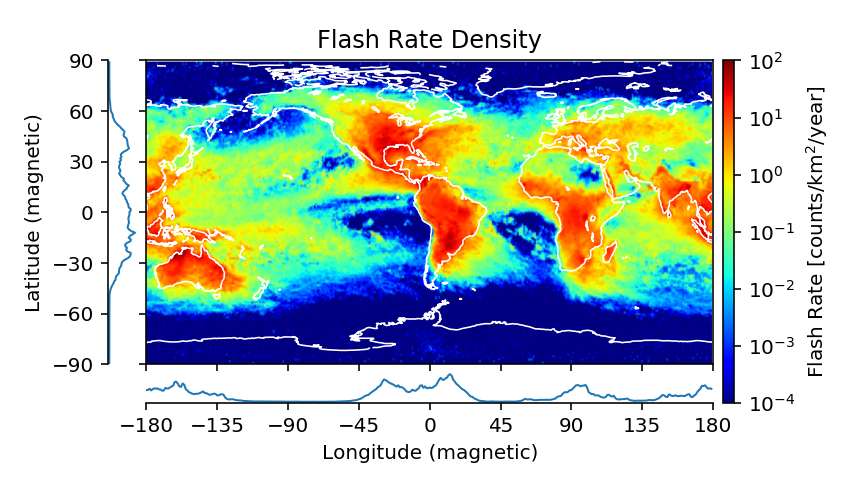

<IPython.core.display.Javascript object>


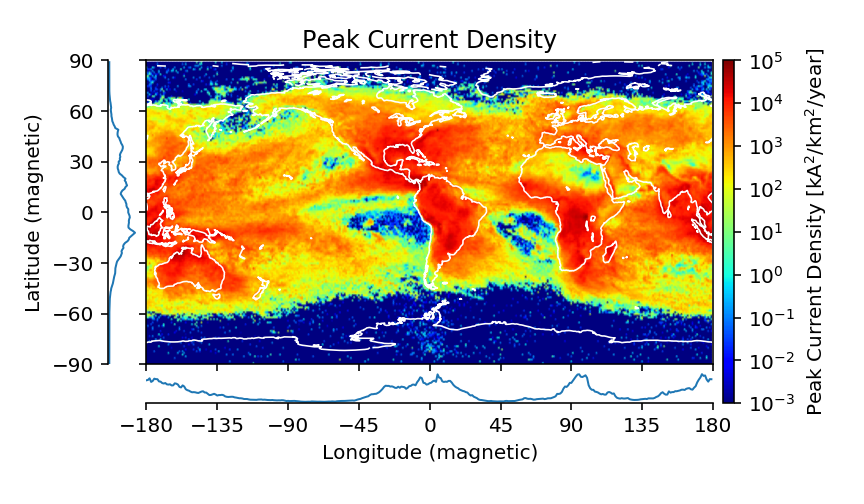

In [40]:
sec_in_year = 60*60*24*365.25
print sec_in_year

# Plot annual flash occurance rate
fig, ax, cb = plot_a_thing(sec_in_year*flash_map/cell_areas[:,np.newaxis], clims=[-4,2])
ax.set_title('Flash Rate Density')
cb.set_label('Flash Rate [counts/km$^2/$year]')
fig.savefig('flash_rate_density.png', dpi=300)

# Plot annual peak current squared density
fig, ax, cb = plot_a_thing(sec_in_year*cur_map/1000./1000./cell_areas[:,np.newaxis], clims=[-3,5])
ax.set_title('Peak Current Density')
cb.set_label('Peak Current Density [kA$^2$/km$^2/$year]')
fig.savefig('peak_current_density.png', dpi=300)

In [21]:
ax2.spines

[u'left', u'right', u'bottom', u'top']

In [44]:
d = os.listdir(data_path)
files = [x for x in d if x.endswith('.pklz')]
intimes = [datetime.datetime.strptime(x[:-5],'%m_%d_%Y_%H_%M') for x in d if x.endswith('.pklz')]

print intimes[0]
print intimes[-1]

2014-08-22 09:00:00
2016-03-28 15:00:00
